# Оценка корректности проведения и результатов A/B-теста

In [193]:
# импортируем необходимые для исследования библиотеки: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import math as mth
import warnings
import scipy.stats as st
import seaborn as sns

## Цель исследования

Оценить корректность проведения теста и результаты

##  Ход исследования 

● Знакомство с данными (считываем датасеты, определяем количество пользователей, даты, представленные в датасетах). Оцениваем наличие/отсутствие данных для оценки теста.

● Предобработка данных 
Обработка пропусков

Обработка дубликатов

Приводим типы данных к нужному формату

● Проверка данных на соответсвтие ТЗ. Фильтрация при необходимости

Фильтрация датафреймов по дате

Фильтрация датафреймов по тесту

Фильтрация датафреймов по региону

Оценка условия: 15% новых пользователей из региона Европа

Оценка влияния рекламной компании на активность пользователей

Объединение отфильтрованных датасетов

Подсчёт количества пользователей, не совершавших события после регистрации

Фильтрация событий, которые совершили пользователи после 14 дня от момента регистрации

Пользователи с лайфтаймом менее 14 дней.

Оценка условия- ожидаемое количество участников

● Исследование теста

Распределение количества пользователей по группам

Среднее количество событий на каждого пользователя в разных группах(медиана)

Количество регистраций пользователей  по дням в каждой группе

Средняя сумма чека на пользователя 

Распределение устройств пользователей по группам

Воронка событий 

Проверка разницы конверсии пользователей на разные этапы стат тестом проверяем разницу между группами

● Вывод

● Рекомендации

## Предобработка данных

### Обзор данных

In [194]:
#данные о событиях 
events = pd.read_csv ('https://code.s3.yandex.net/datasets/final_ab_events.csv')
display(events.head())
events.info()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [195]:
events['user_id'].nunique()

58703

In [196]:
events['event_dt'].min()

'2020-12-07 00:00:33'

In [197]:
events['event_dt'].max()

'2020-12-30 23:36:33'

In [198]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

*В датасете events представлены данные 58703 уникальных пользователей за период с 07 декабря по 30 декабря 2020 года, совершивших 4 уникальных дейстия*.

*Обращает внимание, что для оценки активности новых пользователей в течение 14 дней, зарегистрировавшихся с 17 декабря по 21 декабря данных недостаточно.*

In [199]:
# данные о рекламных компаниях
marketing_events = pd.read_csv ('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
print(marketing_events.head())
marketing_events.info()

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [200]:
marketing_events['name'].nunique()

14

In [201]:
marketing_events['regions'].nunique()

6

In [202]:
marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [203]:
marketing_events['start_dt'].min()

'2020-01-25'

In [204]:
marketing_events['start_dt'].max()

'2020-12-30'

In [205]:
marketing_events['finish_dt'].min()

'2020-02-07'

In [206]:
marketing_events['finish_dt'].max()

'2021-01-07'

*В датасете marketing_events представлены данные о рекламных компаниях, проводимых в 6 различных группах регионов(внутри групп некоторые регионы повторяются) в период с 25 января 2020 года по 07 января 2021 года.*

In [207]:
# данные о регистрации пользователей
new_users = pd.read_csv ('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
print(new_users.head())
new_users.info()

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [208]:
new_users['user_id'].nunique()

61733

In [209]:
new_users['first_date'].min()

'2020-12-07'

In [210]:
new_users['first_date'].max()

'2020-12-23'

In [211]:
new_users['region'].nunique()

4

In [212]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [213]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [214]:
new_users['device'].nunique()

4

*В датасете new_user представлены данные 61733 уникальных пользователей, которые зарегистрировались в период с 07 декабря 2020 по 23 декабря 2020 года в 4 различных регионах на 4  различных видах устройств.*

In [215]:
# данные о проводимых тестах
participants = pd.read_csv ('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
print(participants.head())
participants.info()

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [216]:
participants['user_id'].nunique()

16666

In [217]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

In [218]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

 *В датасете participants представлены данные 16666 уникальных пользователей, распределённых между группами A и B, участвующих в 2 различных A/B-тестах.*

 ### Названия столбцов

*Отображены в змеином регистре во всех представленных датасетах.*

### Пропуски

In [219]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

*Выявлены пропуски в столбце details, содержащими данные о стоимости покупки.
С учётом того, что в ходе тестирования необходимо оценить увеличение/уменьшение конверсии в покупку, а не её стоимость, пропуски в данном столбце решено оставить без изменений*.

In [220]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [221]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [222]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

###  Дубликаты

In [223]:
events.duplicated().sum()

0

In [224]:
marketing_events.duplicated().sum()

0

In [225]:
new_users.duplicated().sum()

0

In [226]:
participants.duplicated().sum()

0

*Явные дубликаты в представленных датасетах не обнаружены*

### Типы данных

In [227]:
# Приводим типы данных к нужному формату
events['event_dt'] = pd.to_datetime(events['event_dt'])
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

## Проверка данных на соответсвтие ТЗ. Фильтрация при необходимости

### Фильтрация датафреймов по дате

#### Датафрейм new_users

In [228]:
# Проводим срез таблицы new_users согласно ТЗ. 
new_users_filtered_date = new_users.query('first_date <"2020-12-22"')

*Минимальная дата регистрации в датафрейме new_users (2020-12-07)соответствует ТЗ. Срез проводим только по дате остановки набора новых пользователей*

In [229]:
new_users_filtered_date['user_id'].nunique()

56470

In [230]:
lost_by_date = (events['user_id'].nunique()-new_users_filtered_date['user_id'].nunique())*100/new_users['user_id'].nunique()
lost_by_date

3.617190157614242

*В ходе фильтрации по дате регистрации пользователя удалено 3,6% уникальных пользователей датафрейма new_users*

#### Датафрейм events

*Согласно ТЗ ожидается что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики. Следовательно, срез датафрейма events нужно провести по схеме: минимальная дата регистрации +14 дней (21 декабря 2020 ) - максильная дата регистрации +14 дней (04 января 2021)*. 

*В датафрейме events представлены данные за период 07 декабря по 30 декабря 2020 года. Срез выполнять не нужно.*

#### Датафрейм marketing_events

*Чтобы отследить влияние проводимых рекламных акций необходимо исключить из анализа рекламные акции, которые  НЕ проходили в период с  07 декабря 2020 (минимальная дата регистрации пользователя) по 04 января 2021 (максильная дата регистрации +14 дней)*.

In [231]:
# Проводим срез датафрейма, оставляя только акции, которые проходили во время проведения теста
marketing_events_filtered_by_date = marketing_events[(marketing_events['start_dt'] < '2021-01-05') & (marketing_events['finish_dt'] > '2020-12-06') & (marketing_events['finish_dt'] < '2021-01-05')]

In [232]:
marketing_events_filtered_by_date

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


*В даты проведения теста проходила только одна рекламная компания. Регион рекламной компании ('EU, N.America') соответсвует ТЗ. Дополнительный срез по региону проводить не нужно.*  

### Фильтрация датафреймов по  тесту

*В датасете participants представлены 2 теста с разделением пользователей на 2 группы A и B.
За время проведения теста одновременно проводился другой тест -'interface_eu_test'. Определяем пересекались ли пользователи в тестах.*

In [233]:
participans_intersection = participants.pivot_table(index='user_id', values='ab_test', aggfunc='count')
participans_intersection[participans_intersection['ab_test']==2].count() 

ab_test    1602
dtype: int64

*Одновременно в двух тестах участвовали 1602 пользователя.*
*С учётом того, группа A - контрольная группа и воздействия на пользователей практически нет исключение пользователей группы A теста 'interface_eu_test' нецелесообразно.* 
*Для принятия решение о необходимости удаления пользователей группы B теста interface_eu_test необходимо посмотреть на распределение пользователей внутри групп А и B теста recommender_system_test.*

In [234]:
# Выделяем список пользователей, которые попали в группу B теста interface_eu_test 
participants_interface_b = participants.query('ab_test == "interface_eu_test" and group == "B"')
interface_b_list = participants_interface_b['user_id'].tolist()

In [235]:
# Выполняем срез датафрейма participants для пользателей группы A теста recommender_system_test
participants_recommender_a = participants.query('ab_test == "recommender_system_test" and group == "A"')

In [236]:
# Определяем пересечение пользователей теста recommender_system_test группы A и пользователей теста interface_eu_test группы B
ba_test = participants_recommender_a['user_id'].isin(interface_b_list)
ba_test.value_counts()

False    3385
True      439
Name: user_id, dtype: int64

In [237]:
# Выполняем срез датафрейма participants для пользателей группы B теста recommender_system_test
participants_recommender_b = participants.query('ab_test == "recommender_system_test" and group == "B"')

In [238]:
# Определяем пересечение пользователей теста recommender_system_test группы A и пользователей теста interface_eu_test группы B
bb_test = participants_recommender_b['user_id'].isin(interface_b_list)
bb_test.value_counts()

False    2533
True      344
Name: user_id, dtype: int64

In [239]:
# Расчёт доли пользователей группы B теста  interface_eu_test в группе  A теста recommender_system_test
participants_test_clear = participants.query('ab_test == "recommender_system_test"')
participants_test_clear['user_id'].nunique()

6701

In [240]:
ba_test_percent = (ba_test.value_counts()/participants_test_clear['user_id'].nunique())*100
ba_test_percent

False    50.514849
True      6.551261
Name: user_id, dtype: float64

In [241]:
bb_test_percent = (bb_test.value_counts()/participants_test_clear['user_id'].nunique())*100
bb_test_percent

False    37.800328
True      5.133562
Name: user_id, dtype: float64

*В группе А теста recommender_system_test присутствует 6,5%, а в группе B-5.1%  пользователей группы B теста interface_eu_test.* 

*Так как распределение по группам A и B теста recommender_system_test пользователей входящих в группу B теста interface_eu_test практически равномерное принятно решено не исключать этих пользователей из дальнейшего анализа.* 

In [242]:
 # Итоговый срез датафрейма по тесту на основе полученных данных
participants_final = participants.query('ab_test == "recommender_system_test"')

### Фильтрация датафреймов по региону

In [243]:
# Проводим фильтрацию ранее отфильтровованного по дате датасета new_users
new_users_filtered_by_region_and_date = new_users_filtered_date.query('region == "EU"')

In [244]:
# Считаем сколько пользователей было удалено на этом этапе
lost_new_users_by_region = (new_users_filtered_date['user_id'].nunique()-new_users_filtered_by_region_and_date['user_id'].nunique())*100/new_users_filtered_date['user_id'].nunique()
lost_new_users_by_region

25.022135647246326

*При дальнейшей фильтрации данных датафрейма new_users  удалено 25% пользователей*

### Оценка условия: 15% новых пользователей из региона Европа

In [245]:
# Для оценки доли участников теста из Европы соединим 2 датафрейма new_users_filtered_by_region_and_date и participants_final
join_part_new_users = participants_final.merge(new_users_filtered_by_region_and_date, on='user_id')

Для оценки доли зарегистрированных в тесте пользователей из Европы в даты, соответствующие ТЗ разделим количество уникальных пользователей отфильтрованного датасета (по тесту, региону, датам)  на количество уникальных пользователей, зарегистрированных в указанные даты в Европе

In [246]:
round(join_part_new_users['user_id'].nunique()/new_users_filtered_by_region_and_date['user_id'].nunique()*100)

15

*Доля пользователей, зарегистрированных в Европе в указанные даты в тесте recommender_system_test составляет 15%, что соответствует ТЗ.*

### Оценка влияния рекламной компании на активность пользователей

In [247]:
# округляем дату датафрейма events до дня
events['event_dt'] = events['event_dt'].dt.date

In [248]:
# считаем количество событий по дням изучаемого периода
events_by_day = events.pivot_table(index = 'event_dt', values = ['event_name'], aggfunc = 'count')
events_by_day =  events_by_day.reset_index()

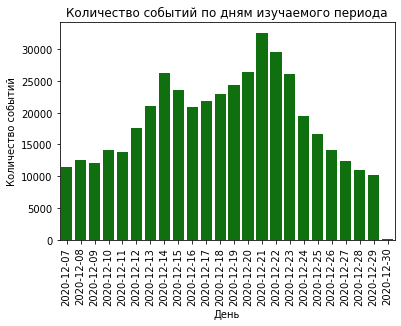

In [249]:
# Визуализируем полученные данные
# строим столбчатую диаграмму
ax = sns.barplot(x='event_dt', y='event_name', data=events_by_day, color='green')
plt.title ('Количество событий по дням изучаемого периода')
plt.ylabel ('Количество событий')
plt.xlabel ('День')
plt.xticks(rotation=90);

*Рекламная акция проведённая в данном регионе в даты исследуемого периода началась 25 декабря 2020 года. После этой даты резких скачков активности пользователей не было выявлено.
В проведении дополнительной фильтрации датафрейма нет необходимости.*

### Объединение таблиц

*Для дальнейшего анализа необходимо объединить 3 датасета: events, new_users_filtered_by_region_and_date и participants_test причём в объединённый датасет должны войти пользователи, информация о которых представлена во всех 3 датафреймах, так как для оценки эффективности и корректности теста, а также соответствия критериям ТЗ нужны данные из всех 3х датафреймов.*

*Методом объединения выбран merge по столбцу 'user_id'.*

### Датафреймы participants_final и events

In [250]:
# Объединяем датафреймы 
join_part_events = participants_final.merge(events, on='user_id')
# Считаем потери данных от общего количества пользователей теста  recommender_system_test на данном этапе
lost_join_part_events = round((participants_final['user_id'].nunique() - join_part_events['user_id'].nunique())/participants_final['user_id'].nunique()*100)
print('Потери на этапе объединения таблиц participants_final и events составляют', lost_join_part_events, '%')

Потери на этапе объединения таблиц participants_final и events составляют 45 %


### Датафреймы  new_users_filtered_by_region_and_date и объединённый датафрейм join_part_events

In [251]:
# Объединяем датафреймы 
join_all = join_part_events.merge(new_users_filtered_by_region_and_date, on='user_id')
# Считаем потери данных от общего количества пользователей теста  recommender_system_test на данном этапе
lost_join_all = round((participants_final['user_id'].nunique() - join_all['user_id'].nunique())/participants_final['user_id'].nunique()*100)
print('Потери на этапе объединения таблиц new_users_filtered_by_region_and_date и join_part_events составляют', lost_join_all,  '%')

Потери на этапе объединения таблиц new_users_filtered_by_region_and_date и join_part_events составляют 48 %


In [252]:
# Проверяем объединенный датафрейм на наличие пропусков
join_all.isna().sum()

user_id           0
group             0
ab_test           0
event_dt          0
event_name        0
details       20224
first_date        0
region            0
device            0
dtype: int64

*Выявлены пропуски только в столбце details. Данные этого столбца не повлияют на анализ корректности и эффектисности теста. Принято рещение оставить пропуски без изменений.*

###  Срез пользователей, которые не совершали действий после регистрации

In [253]:
# Создаём сводную таблицу с подсчётом событий, которое выполнил каждый пользователь
count_events_by_users = join_all.pivot_table(index='user_id', values='event_name', aggfunc='count')

In [254]:
# Делаем срез датафрейма удаляя пользователей, которые совершили только 1 событие
count_events_by_users_active = count_events_by_users.query('event_name >1')
count_events_by_users_active = count_events_by_users_active.reset_index()
# Считаем количество пользователей, которые только зарегистрировались и не совершали событий в дальнейшем
count_events_by_users_active['user_id'].nunique()

3430

In [255]:
# Рассчитываем долю долю потери пользователей на данном этапе
part_active_users = ((join_all['user_id'].nunique() - count_events_by_users_active['user_id'].nunique())/join_all['user_id'].nunique())*100
part_active_users

1.465096236713588

*Всего 96 пользователей (1.19%) отфильтрованного по ТЗ датасета не совершали событий после регистрации. Проведён срез с исключением неактивных пользователей.*

### Фильтрация событий, которые произошли после 14 дней от момента регистрации  пользователя

In [256]:
# приводим столбцы с датами к нужному формату для дальнейших расчётов
join_all['event_dt'] = pd.to_datetime(join_all['event_dt'])
join_all['event_dt'] = join_all['event_dt'].dt.date
join_all['first_date'] = join_all['first_date'].dt.date

In [257]:
# считаем разницу в днях между датой регистрации и датой события и переводим полученные значения в число
join_all['day_of_event'] = (join_all['event_dt'] - join_all['first_date'])/np.timedelta64(1, 'D')

In [258]:
# Проводим срез датафрейма оставляя события, которые совершили пользователи после за 14 дней (с 0 по 13) после регистрации
test_filtered = join_all.query('day_of_event < 14')

### Пользователи с лайфтаймом менее 14 дней

*С учётом того, что в представленных датасетах нет информации о событиях совершённых пользователями после 30 декабря 2020 оценить активность  пользователей, зарегистрированных после 16 декабря в течение полного периода наблюдения (14 дней) нет возможности.* 

*С целью принятия решения о фильтрации пользователей, лайфмайм которых менее 14 дней посмотрим на распределение активности пользователей по дням.*

In [259]:
# Посчитаем на какой день в среднем пользователь совершает действие
join_all_events_count = test_filtered.pivot_table(index='user_id', values='day_of_event', aggfunc=['mean'])
join_all_events_count = join_all_events_count.reset_index()

In [260]:
# Посмотрим на какой день пользователи чаще совершают события
join_all_events_count[('mean', 'day_of_event')].describe()

count    3481.000000
mean        2.427678
std         1.683739
min         0.000000
25%         1.000000
50%         2.333333
75%         3.600000
max         9.500000
Name: (mean, day_of_event), dtype: float64

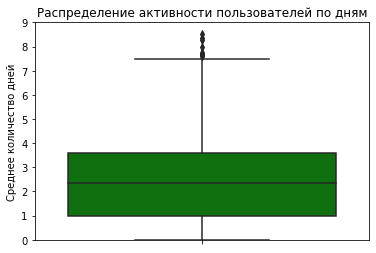

In [261]:
# Визуализируем полученные данные
boxplot = sns.boxplot(y = ('mean', 'day_of_event'), data = join_all_events_count, color='green')
plt.title('Распределение активности пользователей по дням')
plt.ylim(0, 9)
plt.ylabel ('Среднее количество дней');

*Таким образом, мы видим, что максимальная активность пользователей приходится на 2-4 день после регистрации.
После 5 дня пользователи редко совершают действия. Исключение пользователей лайфтайм которых меньше 14 дней  но больше 5 дней нецелеесообразен.*

*Активность всех пользователей в течение 5 дней (включая зарегистрированных в последний день набора- 21 декабря)  по представленным данным оценить возможно.*

### Оценка условия -ожидаемое количество участников (6000)

In [262]:
test_filtered['user_id'].nunique()

3481

*После проведённой последовательной фильтрации по условиям ТЗ осталось 3481 вместо 6000 ожидаемых.*

*Также фиксируем данное отклонение для итоговой оценки корректности проведённого теста.*

## Исследование теста

### Распределение участников теста по группам

In [263]:
test_filtered_a = test_filtered.query('group == "A"')
print('В группе А зарегистрировано', test_filtered_a['user_id'].nunique(), 'пользователя')
test_filtered_a_part = round(test_filtered_a['user_id'].nunique()/test_filtered['user_id'].nunique()*100)
print('Пользователи группы А составляют', test_filtered_a_part, '%  от общего количества участников теста')
#events_by_users = test_filtered_A.pivot_table(index='user_id', values='event_name', aggfunc='count')
#events_by_users

В группе А зарегистрировано 2604 пользователя
Пользователи группы А составляют 75 %  от общего количества участников теста


In [264]:
test_filtered_b = test_filtered.query('group == "B"')
print(test_filtered_b['user_id'].nunique())
test_filtered_b_part = round(test_filtered_b['user_id'].nunique()/test_filtered['user_id'].nunique()*100)
print('Пользователи группы B составляют', test_filtered_b_part, '%  от общего количества участников теста')

877
Пользователи группы B составляют 25 %  от общего количества участников теста


*Обращает внимание неравномерное распределение участников теста между группами.*

*Такое значительное отклонение может привести к серьёзному искажению полученных результатов.*

### Расчёт медианы количества событий на  пользователя  в разных группах

In [265]:
events_by_users_a =  test_filtered_a.pivot_table(index='user_id', values='event_name', aggfunc='count')
events_by_users_a['event_name'].describe()

count    2604.000000
mean        6.849078
std         3.812030
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
Name: event_name, dtype: float64

In [266]:
events_by_users_b =  test_filtered_b.pivot_table(index='user_id', values='event_name', aggfunc='count')
events_by_users_b['event_name'].describe()

count    877.000000
mean       5.456100
std        3.246276
min        1.000000
25%        3.000000
50%        4.000000
75%        8.000000
max       24.000000
Name: event_name, dtype: float64

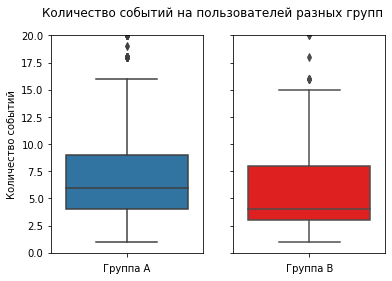

In [267]:
# Графическое отображение полученных результатов
fig, axes = plt.subplots(1, 2, sharey=True)
boxplot_1 = sns.boxplot(y = 'event_name', data = events_by_users_a,  ax=axes[0])
fig.suptitle('Количество событий на пользователей разных групп')
plt.ylim(0, 20)
axes[0].set_ylabel('Количество событий')
axes[0].set_xlabel('Группа А')
boxplot_2 = sns.boxplot(y = 'event_name', data = events_by_users_b, ax=axes[1], color='red')
axes[1].set_ylabel(' ')
axes[1].set_xlabel('Группа B');

*В среднем, пользователи группы А более активны. Медиана количества событий на пользователя группы A -6, пользователя группы B - 4 .* 

### Количество зарегистрированных пользователей в разные группы по дням

In [268]:
# считаем количество регистраций по дням в группе А
events_by_day_a = test_filtered_a.pivot_table(index = 'first_date', values = ['user_id'], aggfunc = 'count')

In [269]:
# считаем количество регистраций по дням в группе B
events_by_day_b = test_filtered_b.pivot_table(index = 'first_date', values = ['user_id'], aggfunc = 'count')

In [270]:
# Подготовка датафрейма для дальнейшей визуализации
# Переименовываем столбцы подсчёта количества зарегистрированных пользователей
events_by_day_a.rename(columns = {'user_id':'new_users_count_a'}, inplace = True )
events_by_day_b.rename(columns = {'user_id':'new_users_count_b'}, inplace = True )
# объединяем датафреймы для дальнейшей визуализации
join_events_by_date = events_by_day_a.join(events_by_day_b, on='first_date', how='left', lsuffix='', rsuffix='', sort=False)

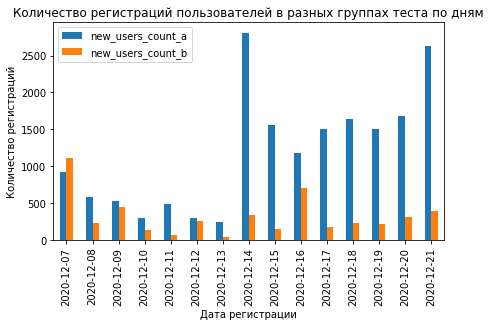

In [271]:
# визуализируем полученные данные
join_events_by_date.plot(kind='bar', figsize=(7, 4))
plt.title ('Количество регистраций пользователей в разных группах теста по дням')
plt.ylabel ('Количество регистраций')
plt.xlabel ('Дата регистрации')
plt.xticks(rotation=90);

*Обращает внимание резкое увеличение количества зарегистрированных  пользователей группы A  после 14 декабря 2020 года. Согласно представленным данным рекламные компании в Европе в это время не проходили. Возможно, это связано с внешними факторами (старт рождественской распродажи?)*

### Средняя сумма потраченная пользователями в разных группах

In [272]:
# Подсчёт средней суммы на пользователем группы A
money_filtered_a = test_filtered_a.pivot_table(index='user_id', values = 'details', aggfunc ='sum') 
money_filtered_a['details'].mean()

22.056509216589866

In [273]:
# Подсчёт средней суммы на пользователя группы B
money_filtered_b = test_filtered_b.pivot_table(index='user_id', values = 'details', aggfunc ='sum') 
money_filtered_b['details'].mean()

16.23012542759407

*Средняя сумма на пользователя группы A выше, однако с учётом ранее выявленных отклонений (неравномерное распределение пользователей по группам, недостаточное количество участников теста, меньший процент зарегистрированных пользователей из Европы, чем ожидалось, резкое увеличение активности пользователей группы А после 14 декабря, которое возможно, связано с новогодними распродажами) делать выводы некорректно.*

### Распределение устройств по группам

In [274]:
# считаем количество устройств в группе А
devices_a = test_filtered_a.pivot_table(index = 'device', values = 'user_id', aggfunc='nunique')
devices_total = devices_a['user_id'].sum()
# считаем долю устройств в группе А
devices_a['part_a'] = round(devices_a['user_id']/devices_a['user_id'].sum()*100)
devices_a

,user_id,part_a
device,,
Android,1139,44.0
Mac,255,10.0
PC,689,26.0
iPhone,521,20.0


In [275]:
# считаем количество устройств в группе B
devices_b = test_filtered_b.pivot_table(index = 'device', values = 'user_id', aggfunc='nunique')
devices_total = devices_b['user_id'].sum()
# считаем долю устройств в группе B
devices_b['part_b'] = round(devices_b['user_id']/devices_b['user_id'].sum()*100)
devices_b

,user_id,part_b
device,,
Android,405,46.0
Mac,74,8.0
PC,212,24.0
iPhone,186,21.0


In [276]:
# Подготовка датафрейма для дальнейшей визуализации
# Переименовываем столбцы подсчёта количества зарегистрированных пользователей
devices_a.rename(columns = {'user_id':'users_a'}, inplace = True )
devices_b.rename(columns = {'user_id':'users_b'}, inplace = True )
# объединяем датафреймы для дальнейшей визуализации
join_devices = devices_a.join(devices_b, on='device', how='left', lsuffix='', rsuffix='', sort=False)
join_devices_for_plot = join_devices[['part_a', 'part_b']]

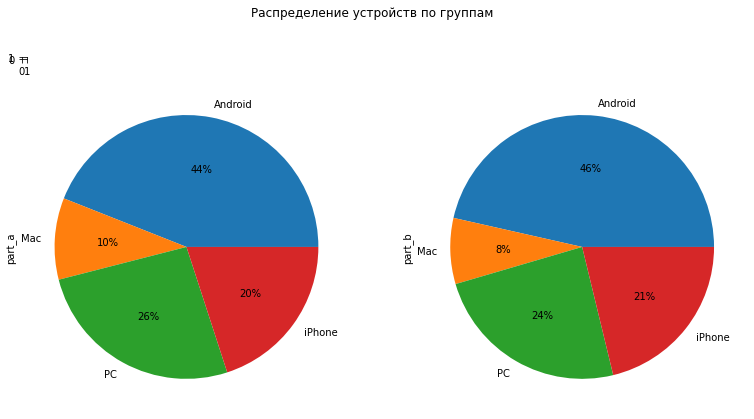

In [277]:
# визуализируем полученные данные
join_devices_for_plot.plot(kind='pie', figsize=(13, 7), subplots=True, legend=False,  autopct='%0.0f%%')
plt.suptitle("Распределение устройств по группам")
plt.subplot(121, 122, 1);

*Значимых различий в распределении устройств пользователей разных групп нет.*

### Построение воронок событий 

In [278]:
# Считаем количество пользователей на разных этапах воронки событий
## Группа А
test_filtered_a_events = test_filtered_a.pivot_table(index = ['event_name'], values = 'user_id', aggfunc='nunique')
#  Проводим индексацию событий в логичном порядке
test_filtered_a_events = test_filtered_a_events.reindex(['login', 'product_page','product_cart', 'purchase'])
## создаём столбец с пометкой группы (для дальнейшего слияния таблиц и визуализации)
test_filtered_a_events['group'] = 'A'
# Считаем количество пользователей на первом этапе login
test_filtered_a_events = test_filtered_a_events.reset_index()
users_login_a = test_filtered_a_events.iloc [0]['user_id']
# считаем долю пользователей на различных этапах по отношению к первому этапу
test_filtered_a_events['part'] = round(test_filtered_a_events['user_id'].apply(lambda x: x/users_login_a)*100)

In [279]:
# Считаем количество пользователей на разных этапах воронки событий
## Группа B
test_filtered_b_events = test_filtered_b.pivot_table(index = ['event_name'], values = 'user_id', aggfunc='nunique')
#  Проводим индексацию событий в логичном порядке
test_filtered_b_events = test_filtered_b_events.reindex(['login', 'product_page','product_cart', 'purchase'])
## создаём столбец с пометкой группы (для дальнейшего слияния таблиц и визуализации)
test_filtered_b_events['group'] = 'B'
# Считаем количество пользователей на первом этапе login
test_filtered_b_events = test_filtered_b_events.reset_index()
users_login_b = test_filtered_b_events.iloc [0]['user_id']
# считаем долю пользователей на различных этапах по отношению к первому этапу
test_filtered_b_events['part'] = round(test_filtered_b_events['user_id'].apply(lambda x: x/users_login_b)*100)

In [280]:
# объединяем датафреймы для дальнейшей визуализации
events_for_conversion = pd.concat([test_filtered_a_events, test_filtered_b_events], axis=0)
events_for_conversion = events_for_conversion.reset_index()

In [281]:
# Визуализируем полученные данные
fig = px.funnel(events_for_conversion, x=events_for_conversion['part'], y='event_name', color='group')
fig.update_layout(title='Конверсия пользователей на разных этапах событий в разрезе групп', title_x = 0.5)
fig.show()

*Вывод по воронке событий:*

*Ожидаемый эффект (за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%) достигнут не был. 
Конверсия в просмотр карточек товаров (product_page) снизилась на 9 %, в просмотры корзины (product_cart) снизилась на 2 %,
в покупки (purchase) также снизилась на 4 %*.

###  Распределение событий по дням

In [282]:
#Подготовка датафреймов
#Группа A
test_filtered_group_a_event_date = test_filtered_a.pivot_table(index=['event_name', 'event_dt'], values='user_id', aggfunc='count')
test_filtered_group_a_event_date = test_filtered_group_a_event_date.reset_index()
#Группа B
test_filtered_group_b_event_date = test_filtered_b.pivot_table(index=['event_name', 'event_dt'], values='user_id', aggfunc='count')
test_filtered_group_b_event_date = test_filtered_group_b_event_date.reset_index()

In [283]:
# Визуализируем полученные данные

figA = px.bar(test_filtered_group_a_event_date, x=test_filtered_group_a_event_date['event_dt'], y='user_id', color='event_name')
figA.update_layout(title='События по дням группа А')
figA.show()

figB = px.bar(test_filtered_group_b_event_date, x=test_filtered_group_b_event_date['event_dt'], y='user_id', color='event_name')
figB.update_layout(title='События по дням группа B')
figB.show()

*На представленных графиках мы видим, что распределение событий по дням неравномерное. Распределение активности пользователей разнных групп также отличается.*

*Например, пользователи группы B были более активны сразу после регистрации, чем пользователи группы A.*

*У пользователей группы А наблюдается плавное нарастание активности к 21 декабря с последующим плавным снижением активности к 30 декабря.*

*У пользователей же группы B наблюдаются хаотичные резкие всплески активности в точках 7, 9, 26 и 21 декабря.*

### Особенности данных, которые нужно учесть, прежде чем приступать к A/B-тестированию

Перед проведением теста нужно учесть следующие выявленные отклонения:

Неравномерное распределение участников по группам (пользователи группы А -75 %, пользователи группы B -25 %)

Во время проведения теста проходило ещё одно тестирование interface_eu_test. Выявлено, что 1602 пользователя одновременно участвовали в 2х тестах.

Ожидаемое количество участников составило 3481 вместо 6000.

В представленных данных информация об активности пользователей представлена не в полном объёме. Нет возможности оценить активность пользователей, зарегистрированных после 16 декабря в течение полного периода наблюдения (14 дней).


Даты проведения теста - период новогодних распродаж и новогодних каникул, что также может повлиять на поведение пользователей.

Распределение активности пользователей по дням в группах различается. 

Пользователи не всегда проходят этап product_cart. Покупки иногда совершаются без этого этапа. Оценивать конверсию product_cart-purchase нецелесообразно.


### Статистическая разница конверсии на разные этапы в двух группах теста

In [284]:
#Подготовка данных
events_for_stat = events_for_conversion.pivot_table(index=['group', 'event_name'], values = 'user_id')

#### Формулировка гипотезы:

H0-Между конверсией на разные этапы в группах разницы нет

H1-Между конверсией на разные этапы в группах разница есть

#### Функция для расчёта статистического теста

In [285]:
def calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1/trials1
    p2 = successes2/trials2
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

#### Сравнение конверсии этапа login в этап product_page

In [286]:
# Параметры
successes1 = events_for_conversion.iloc [1]['part']
successes2 = events_for_conversion.iloc [5]['part']
trials1 =  events_for_conversion.iloc [0]['part']
trials2 =  events_for_conversion.iloc [4]['part']
calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  0.1929775796858153
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


####  Сравнение конверсии этапа  product_page в product_cart

In [287]:
# Параметры
successes1 = events_for_conversion.iloc [2]['part']
successes2 = events_for_conversion.iloc [6]['part']
trials1 =  events_for_conversion.iloc [1]['part']
trials2 =  events_for_conversion.iloc [5]['part']
calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  0.6728311253592403
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


####  Сравнение конверсии этапа  product_cart в purchase

*С учётом того, что действия пользователей  не всегда происходят в определённом порядке, например, не все кладут товар в корзину перед покупкой, считать конверсию на данном этапе нецелесообразно (количество пользователей, совершивших действие product_cart меньше, чем количество пользователей на этапе purchase.*

####  Сравнение конверсии этапа  login в purchase

In [288]:
# Параметры
successes1 = events_for_conversion.iloc [3]['part']
successes2 = events_for_conversion.iloc [7]['part']
trials1 =  events_for_conversion.iloc [0]['part']
trials2 =  events_for_conversion.iloc [4]['part']
calculate_stat_test(successes1, successes2, trials1, trials2, alpha=0.05)

p-значение:  0.5370939784426416
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


## Выводы

Исследование проведено с целью оценки корректности и результатов проведённого A/B теста (проведён с целью тестирования изменений, связанных с внедрением улучшенной рекомендательной системы; 

На этапе предобработки данных были изменены типы данных (столбцы с датами приведены к необходимому формату).
Явные дубликаты не были обнаружены.
Пропуски выявлены только с столбцах details, содержащими данные о стоимости покупки.
С учётом того, что в ходе тестирования необходимо было оценить увеличение/уменьшение конверсии в покупку, а не её стоимость пропуски в данном столбце решено оставить без изменений.

В ходе проверки данных на соотвествие ТЗ были выявлены многочисленные отклонения: 

● Во время проведения теста проходило ещё одно тестирование interface_eu_test. 
Выявлено, что 1602 пользователя одновременно участвовали в 2х тестах.

● Ожидаемое количество участников составило 3481 вместо 6000. 

● В представленных данных информация об активности пользователей представлена не в полном объёме. Нет возможности оценить активность  пользователей, зарегистрированных после 16 декабря в течение полного периода наблюдения (14 дней).

● Обращает внимание неравномерное распределение участников по группам (пользователи группы А -75 %, пользователи группы B -25 %). 

● Также обращают внимание даты проведения теста - период новогодних распродаж и новогодних каникул, что также может повлиять на поведение пользователей. 


Несмотря на многочисленные несоотвествия условиям проведения теста был проведён анализ активности пользователей.
Построена воронка событий. 

Выявлено, что ожидаемый эффект (за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%) достигнут не был. 
Конверсия в просмотр карточек товаров (product_page) снизилась на 9 %, 

в просмотры корзины (product_cart) - на 2 %,

в покупки (purchase) - на 4 %*.

С целью оценки статистической разницы между конверсией пользователей на разные этапы действий  был выполнен   z-тест. 

Проанализированы следующие этапы:

◦конверсия этапа login в этап product_page

◦конверсия этапа  product_page в product_cart

◦конверсия этапа  login в purchase.

Во всех проведённых тестах p-value>0.05 - нет оснований считать доли разными.



**Таким образом, данных за то, что улучшенная рекомендательная система влияет на поведение пользователей в ходе исследования данных получено не было.
Однако результаты могут быть недостоверными с учётом множественных несоотвествий условиям проведения теста.**

# Рекомендации

Целесообразно повторное проведение теста.
При повторном проведении обратить внимание на 

● равномерное распределение участников по группам

● отсутствие проведение других тестов, которые могут повлиять на поведение пользователей

● период проведение тестирование (оценить факторы, влияющие на активность пользователей, например, отпуска, новогодние распродажи)

● количество зарегистрированных участников из изучаемого региона

● сбор данных пользователей на протяжении всего периода наблюдения

● при выборе периода обратить внимание на запуск рекламных компаний, которые могут влиять на активность пользователей